In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import top_k_accuracy_score
import joblib
from matplotlib import pyplot as plt


In [2]:
# Load data
train = pd.read_csv('playground-series-s5e6/train.csv',index_col='id')
test = pd.read_csv('playground-series-s5e6/test.csv',index_col = 'id')

In [3]:
train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...
749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26


In [4]:
test

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
id,,,,,,,,
750000,31,70,52,Sandy,Wheat,34,11,24
750001,27,62,45,Red,Sugarcane,30,14,15
750002,28,72,28,Clayey,Ground Nuts,14,15,4
750003,37,53,57,Black,Ground Nuts,18,17,36
750004,31,55,32,Red,Pulses,13,19,14
...,...,...,...,...,...,...,...,...
999995,26,66,30,Red,Sugarcane,14,7,18
999996,33,62,55,Red,Pulses,28,14,7
999997,36,53,64,Black,Paddy,28,11,27


In [5]:
train['Fertilizer Name'].unique()

array(['28-28', '17-17-17', '10-26-26', 'DAP', '20-20', '14-35-14',
       'Urea'], dtype=object)

In [6]:
# Derived features
train['Total_NPK'] = train['Nitrogen'] + train['Phosphorous'] + train['Potassium']
train['N_to_P'] = train['Nitrogen'] / (train['Phosphorous'] + 1)
train['N_to_K'] = train['Nitrogen'] / (train['Potassium'] + 1)

# Categorical interactions
train['Crop_Soil'] = train['Crop Type'] + "_" + train['Soil Type']

# Label encoding
label_encoder = LabelEncoder()
y_final = label_encoder.fit_transform(train['Fertilizer Name'])

# Vocab lookups
soil_vocab = train['Soil Type'].unique().tolist()
crop_vocab = train['Crop Type'].unique().tolist()
crop_soil_vocab = train['Crop_Soil'].unique().tolist()

soil_lookup = {v: i for i, v in enumerate(soil_vocab)}
crop_lookup = {v: i for i, v in enumerate(crop_vocab)}
crop_soil_lookup = {v: i for i, v in enumerate(crop_soil_vocab)}

train['Soil Type Enc'] = train['Soil Type'].map(soil_lookup)
train['Crop Type Enc'] = train['Crop Type'].map(crop_lookup)
train['Crop_Soil Enc'] = train['Crop_Soil'].map(crop_soil_lookup)

# Final numeric features
num_cols = ['Temparature', 'Humidity', 'Moisture',
            'Nitrogen', 'Phosphorous', 'Potassium',
            'Total_NPK', 'N_to_P', 'N_to_K']
scaler = StandardScaler()
X_num = scaler.fit_transform(train[num_cols])

# Final categorical features
X_soil = train['Soil Type Enc'].values
X_crop = train['Crop Type Enc'].values
X_crop_soil = train['Crop_Soil Enc'].values

# Split dataset
X_num_train, X_num_val, X_soil_train, X_soil_val, X_crop_train, X_crop_val, X_crop_soil_train, X_crop_soil_val, y_train, y_val = train_test_split(
    X_num, X_soil, X_crop, X_crop_soil, y_final,
    test_size=0.2, random_state=25, stratify=y_final
)

# Inputs
input_num = Input(shape=(X_num.shape[1],))
input_soil = Input(shape=(1,))
input_crop = Input(shape=(1,))
input_crop_soil = Input(shape=(1,))

# Embedding layers
soil_embed = Flatten()(Embedding(input_dim=len(soil_vocab), output_dim=8)(input_soil))
crop_embed = Flatten()(Embedding(input_dim=len(crop_vocab), output_dim=8)(input_crop))
crop_soil_embed = Flatten()(Embedding(input_dim=len(crop_soil_vocab), output_dim=12)(input_crop_soil))

# Merge all inputs
x = Concatenate()([input_num, soil_embed, crop_embed, crop_soil_embed])

In [7]:
# MAP@3 scorer
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        p = p[:k]
        score = 0.0
        hits = 0
        seen = set()
        for i, pred in enumerate(p):
            if pred in a and pred not in seen:
                hits += 1
                score += hits / (i + 1.0)
                seen.add(pred)
        return score / min(len(a), k)
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

from keras.metrics import sparse_top_k_categorical_accuracy

# Define sparse top-3 accuracy
def sparse_top_3_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

In [8]:
# Try increasing model capacity
x = Dense(300, activation='gelu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

x = Dense(300, activation='gelu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(300, activation='gelu')(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)

output = Dense(len(label_encoder.classes_), activation='softmax')(x)
model = Model(inputs=[input_num, input_soil, input_crop, input_crop_soil], outputs=output)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │         40 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │         88 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 12)     │        660 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37)        │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │     11,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300)       │      1,200 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 300)       │     90,300 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300)       │      1,200 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 300)       │     90,300 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300)       │      1,200 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 198,495 (775.37 KB)

 Trainable params: 196,695 (768.34 KB)

 Non-trainable params: 1,800 (7.03 KB)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

from keras.optimizers.schedules import CosineDecayRestarts

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=0.003,
    first_decay_steps=30,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)


In [11]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', sparse_top_3_accuracy])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

X_num_train, X_num_val, X_soil_train, X_soil_val, X_crop_train, X_crop_val, X_crop_soil_train, X_crop_soil_val, y_train, y_val = train_test_split(
    X_num, X_soil, X_crop, X_crop_soil, y_final, test_size=0.2, random_state=25, stratify=y_final
)

history = model.fit(
    [X_num_train, X_soil_train, X_crop_train, X_crop_soil_train], y_train,
    validation_data=([X_num_val, X_soil_val, X_crop_val, X_crop_soil_val], y_val),
    epochs=150,
    batch_size=512,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict
)


Epoch 1/150
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.1453 - loss: 2.0288 - sparse_top_3_accuracy: 0.4353 - val_accuracy: 0.1538 - val_loss: 1.9530 - val_sparse_top_3_accuracy: 0.4488
Epoch 2/150
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1528 - loss: 1.9539 - sparse_top_3_accuracy: 0.4482 - val_accuracy: 0.1509 - val_loss: 1.9512 - val_sparse_top_3_accuracy: 0.4461
Epoch 3/150
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1551 - loss: 1.9493 - sparse_top_3_accuracy: 0.4542 - val_accuracy: 0.1581 - val_loss: 1.9420 - val_sparse_top_3_accuracy: 0.4577
Epoch 4/150
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1588 - loss: 1.9442 - sparse_top_3_accuracy: 0.4605 - val_accuracy: 0.1555 - val_loss: 1.9472 - val_sparse_top_3_accuracy: 0.4549
Epoch 5/150
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1576 - loss: 1.9454 - sparse_top_3_accuracy: 0.4593 - val_accuracy: 0.1556 - val_loss: 1.9441 - val_sparse_top_3_accuracy: 0.4

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 4s 904us/step
📊 MAP@3 Score: 0.4662


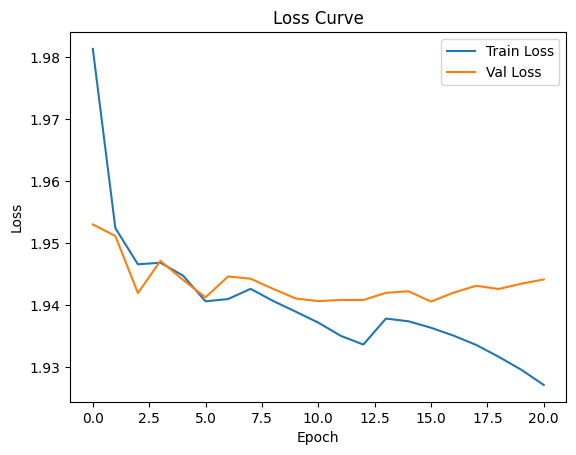

In [12]:
val_probs = model.predict([X_num_val, X_soil_val, X_crop_val, X_crop_soil_val])
map3_score = top_k_accuracy_score(y_val, val_probs, k=3)
print(f"📊 MAP@3 Score: {map3_score:.4f}")

# Plotting
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [13]:
# Save model
joblib.dump(model, 'ann_model03.joblib')
print(f"💾 Saved model as ann_model03.joblib")

💾 Saved model as ann_model03.joblib


In [50]:
# Apply derived features
test['Total_NPK'] = test['Nitrogen'] + test['Phosphorous'] + test['Potassium']
test['N_to_P'] = test['Nitrogen'] / (test['Phosphorous'] + 1)
test['N_to_K'] = test['Nitrogen'] / (test['Potassium'] + 1)
test['Crop_Soil'] = test['Crop Type'] + "_" + test['Soil Type']

# Encode categorical columns
test['Soil Type Enc'] = test['Soil Type'].map(soil_lookup).fillna(0).astype(int)
test['Crop Type Enc'] = test['Crop Type'].map(crop_lookup).fillna(0).astype(int)
test['Crop_Soil Enc'] = test['Crop_Soil'].map(crop_soil_lookup).fillna(0).astype(int)

# Scale numeric features
X_test_num = scaler.transform(test[num_cols])

# Prepare categorical inputs
X_test_soil = test['Soil Type Enc'].values
X_test_crop = test['Crop Type Enc'].values
X_test_crop_soil = test['Crop_Soil Enc'].values

# Predict
test_probs = model.predict([X_test_num, X_test_soil, X_test_crop, X_test_crop_soil], verbose=0)

# Get top-3 label indices
top3_test = np.argsort(test_probs, axis=1)[:, -3:][:, ::-1]

# Convert indices back to fertilizer names
top_3_labels = [[label_encoder.classes_[i] for i in row] for row in top3_test]

In [51]:
df_sub = pd.read_csv("playground-series-s5e6/sample_submission.csv")

submission = pd.DataFrame({
    'id': df_sub['id'],
    'Fertilizer Name': [' '.join(row) for row in top_3_labels]
})

submission

,id,Fertilizer Name
0,750000,17-17-17 14-35-14 28-28
1,750001,17-17-17 10-26-26 14-35-14
2,750002,20-20 28-28 10-26-26
3,750003,14-35-14 28-28 10-26-26
4,750004,17-17-17 20-20 14-35-14
...,...,...
249995,999995,17-17-17 10-26-26 14-35-14
249996,999996,14-35-14 10-26-26 17-17-17
249997,999997,14-35-14 28-28 DAP
249998,999998,17-17-17 10-26-26 DAP


In [52]:
submission.to_csv('ann_submission03.csv', index=False)
print("✅ Saved test set predictions to ann_submission03.csv")

✅ Saved test set predictions to ann_submission02.csv


In [53]:
n_classes = 7

df = pd.DataFrame(test_probs, columns=[f'class_{i}' for i in range(n_classes)])
df.to_csv('ANN_prob03.csv', index=False)